# Распознавание жанров музыки. 10 жанров. Используется библиотека librosa для извлечения из аудио различных спектральных компонентов. В даннмо примере MFCC коэффициенты.

In [ ]:
#Подключаем библиотеки
from google.colab import files
from tensorflow.keras.utils import to_categorical
import os
import librosa
import numpy as np
import matplotlib.pyplot as plt
 
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import concatenate, Input, Dense, Dropout, BatchNormalization, Flatten, Conv1D, Conv2D, LSTM
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from keras.utils.vis_utils import plot_model
from tensorflow.keras.callbacks import LambdaCallback, ModelCheckpoint
from keras.models import load_model
import seaborn as sns
sns.set_style('darkgrid')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip -q '/content/drive/MyDrive/Базы/genres.zip'

genres = os.listdir('genres')


#Предобработка и создание обучающей и проверочной выборки

In [ ]:
def get_features(y, sr):
  
  mfcc = librosa.feature.mfcc(y=y, sr=sr)
  
  out = mfcc 
 
  return out

In [ ]:
import time

X_train_0 = []
Y_train_0 = []
curr_time = time.time()

for i in range(len(genres)):
  g = genres[i] 
  
  for filename in os.listdir(f'./genres/{g}'):
    
    songname = f'./genres/{g}/{filename}'
    y, sr = librosa.load(songname, mono=True, duration=30) 
    out = get_features(y, sr)
    X_train_0.append(out)
    Y_train_0.append(to_categorical(i, len(genres)))
 
  print("Жанр ", g, " готов -> ", round(time.time() - curr_time), "c", sep="")
  curr_time = time.time()
  print(len(X_train_0))
X_train_0 = np.array(X_train_0)
Y_train_0 = np.array(Y_train_0)

Жанр classical готов -> 47c
100
Жанр metal готов -> 47c
200
Жанр disco готов -> 46c
300
Жанр reggae готов -> 46c
400
Жанр jazz готов -> 47c
500
Жанр country готов -> 47c
600
Жанр hiphop готов -> 46c
700
Жанр pop готов -> 46c
800
Жанр blues готов -> 46c
900
Жанр rock готов -> 45c
1000


In [ ]:
X_train_0

array([[2.15054732e-02, 9.49460832e+02, 1.11224541e+03, ...,
        1.46308541e-01, 1.45296052e-01, 2.74265945e-01],
       [3.89561392e-02, 1.47480338e+03, 1.81331646e+03, ...,
        3.67591262e-01, 3.84698391e-01, 2.98593849e-01],
       [1.34665444e-01, 1.32731443e+03, 1.32671884e+03, ...,
        4.34367448e-01, 1.35830805e-01, 2.81216562e-01],
       ...,
       [1.22628249e-01, 3.48900912e+03, 3.24174226e+03, ...,
        4.70421672e-01, 3.08328062e-01, 4.47263539e-01],
       [1.28266469e-01, 1.18154237e+03, 1.60787727e+03, ...,
        2.84630060e-01, 1.44534320e-01, 3.23849529e-01],
       [1.33781165e-01, 1.59648026e+03, 2.23777684e+03, ...,
        4.24044400e-01, 5.37528992e-01, 4.01271760e-01]])

In [ ]:
Y_train_0

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.]], dtype=float32)

In [ ]:
X_train2 = X_train_0.copy()
Y_train2 = Y_train_0.copy()

In [ ]:
y_train_class = np.argmax(Y_train_0, axis=1)
print(y_train_class)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 

In [ ]:
print(X_train_0.shape)
print(Y_train_0.shape)
print(y_train_class.shape)

(1000, 37)
(1000, 10)
(1000,)


In [ ]:

scaler = StandardScaler()
X_train_0 = scaler.fit_transform(X_train_0)

In [ ]:
print(X_train_0)

[[-1.66670479 -1.75009455 -2.14858229 ... -2.12945231 -2.0002193
  -0.85799743]
 [-1.4009008  -1.01596914 -0.81593617 ... -0.26568641  0.08256532
  -0.64757925]
 [ 0.05691834 -1.2220735  -1.74089581 ...  0.29673969 -2.08256633
  -0.79787979]
 ...
 [-0.12642908  1.79872694  1.89931803 ...  0.60040838 -0.58185152
   0.63830242]
 [-0.04054919 -1.42577863 -1.20644971 ... -0.9644317  -2.00684632
  -0.4291365 ]
 [ 0.04344922 -0.84593515 -0.00909143 ...  0.20979326  1.4121815
   0.24050792]]


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_train_0, y_train_class, test_size=0.1, stratify = y_train_class)

In [ ]:

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(900, 37)
(900,)
(100, 37)
(100,)


#Опыты с нейронками

## На втором графике точности в пике точность достигала 86%.
#№ Модель с самой примитивной архитектурой, эффекти достигнут за счет оптимизаии параметров, стоит заметить что из за недостаточного количества данных очень сильно влияет сплит на тестовую и тренировочную выборку.  При одних сплитах она может быть не выше 60%, а временами достигала 90%.

In [ ]:
acc={}
los={}
for i in [1 ]:
    print('--------------------------',i, '---------------------------')
    #best__loss = ModelCheckpoint('best_loss.h5', save_best_only=True, monitor='val_loss', mode='min')
    #best__accuracy = ModelCheckpoint('best_accuracy.h5', save_best_only=True, monitor='val_accuracy', mode='max')
    model = Sequential()
    model.add(Dense(200, activation='elu', input_shape=(X_train.shape[1],) ))
    # model.add(Dropout(0.25))
    model.add(BatchNormalization())
    model.add(Dense(100, activation='elu'))
    # model.add(Dropout(0.25))
    # model.add(Dense(50, activation='linear'))
    # model.add(Dropout(0.25))
    model.add(Dense(len(genres), activation='softmax'))
    
    
    #Компилируем сеть
    model.compile(optimizer=RMSprop(lr=1e-3),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    #Обучаем
    history = model.fit(X_train,
                        y_train,
                        epochs=200,
                        batch_size=15,
                        validation_data=(X_test, y_test))
                        #,callbacks=[best__loss, best__accuracy] )
    acc[i] = history.history["val_accuracy"]
    los[i] = history.history["val_loss"]

-------------------------- 1 ---------------------------
Epoch 1/200
60/60 [==============================] - 1s 5ms/step - loss: 1.9463 - accuracy: 0.3343 - val_loss: 1.3853 - val_accuracy: 0.5400
Epoch 2/200
60/60 [==============================] - 0s 2ms/step - loss: 1.1964 - accuracy: 0.6017 - val_loss: 1.2264 - val_accuracy: 0.6100
Epoch 3/200
60/60 [==============================] - 0s 2ms/step - loss: 1.0835 - accuracy: 0.6245 - val_loss: 1.1462 - val_accuracy: 0.6600
Epoch 4/200
60/60 [==============================] - 0s 2ms/step - loss: 0.9564 - accuracy: 0.6788 - val_loss: 1.1103 - val_accuracy: 0.6800
Epoch 5/200
60/60 [==============================] - 0s 2ms/step - loss: 0.8658 - accuracy: 0.6978 - val_loss: 1.0812 - val_accuracy: 0.5800
Epoch 6/200
60/60 [==============================] - 0s 2ms/step - loss: 0.8264 - accuracy: 0.7188 - val_loss: 1.0659 - val_accuracy: 0.6500
Epoch 7/200
60/60 [==============================] - 0s 2ms/step - loss: 0.7406 - accuracy: 0.760

In [ ]:
model = load_model('best_loss.h5')

In [ ]:
model = load_model('best_accuracy.h5')

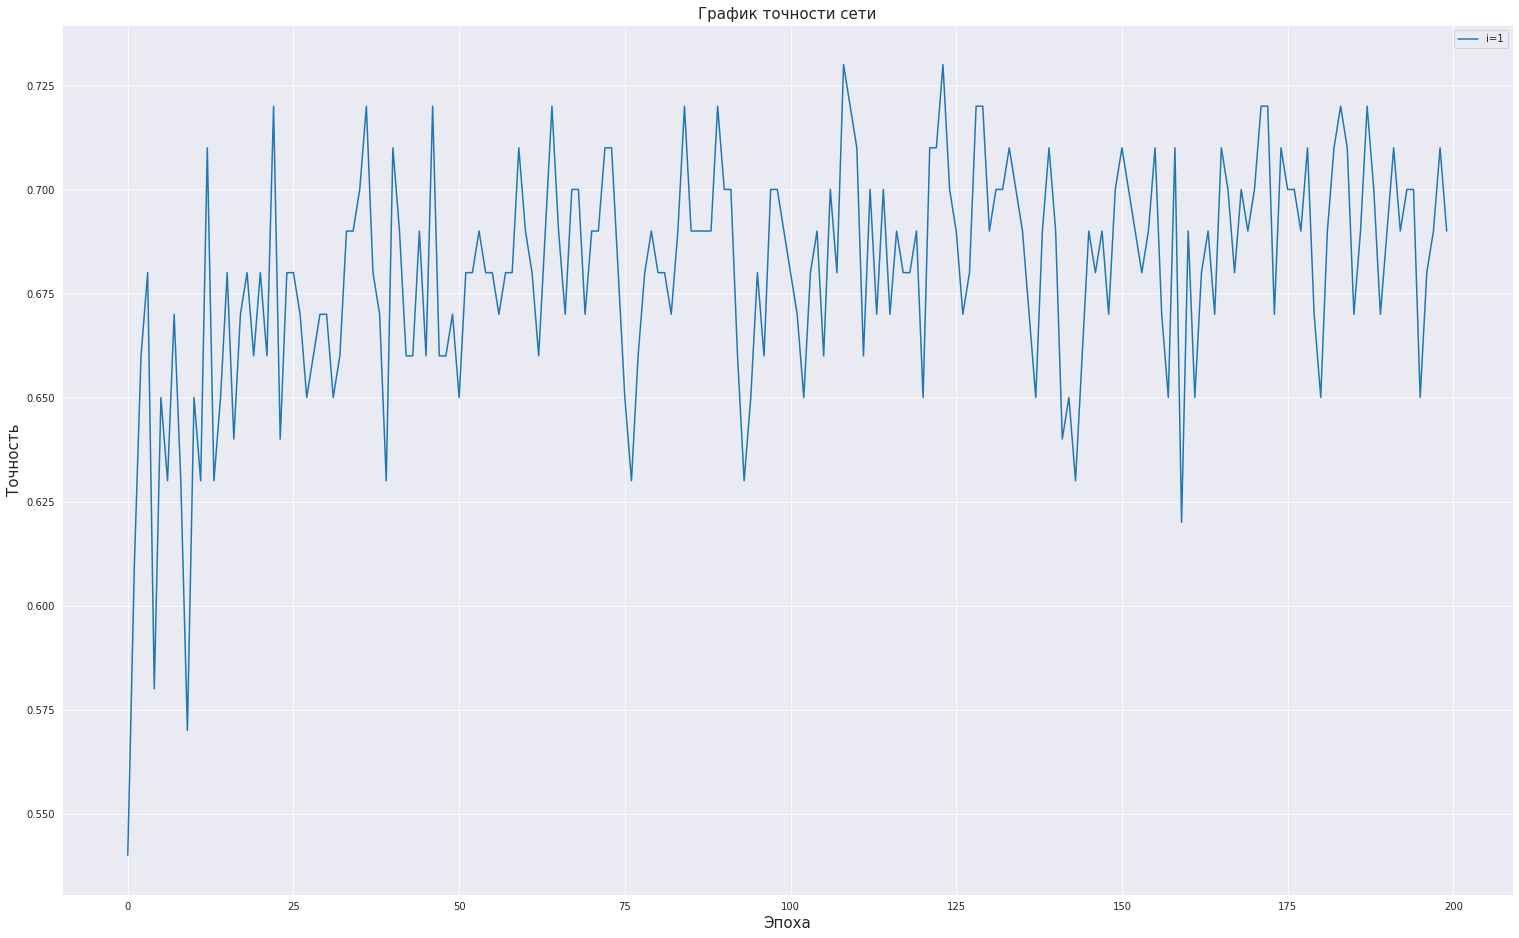

In [ ]:

plt.figure(figsize = (26,16))
for i in acc:
  if i not in [1111]:
    plt.plot(acc[i], label = f"i={i}")

plt.legend()
plt.title('График точности сети', size = 15)
plt.xlabel('Эпоха', size = 15)
plt.ylabel('Точность', size = 15)
plt.show()

#ДООБУЧАЕМ

In [ ]:
#Компилируем сеть
model.compile(optimizer=RMSprop(lr=1e-4),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

#Обучаем
history = model.fit(X_train,
                    y_train,
                    epochs=200,
                    batch_size=15,
                    validation_data=(X_test, y_test))


Epoch 1/200
60/60 [==============================] - 1s 5ms/step - loss: 0.7597 - accuracy: 0.7602 - val_loss: 0.6564 - val_accuracy: 0.8400
Epoch 2/200
60/60 [==============================] - 0s 2ms/step - loss: 0.7996 - accuracy: 0.7189 - val_loss: 0.6591 - val_accuracy: 0.8400
Epoch 3/200
60/60 [==============================] - 0s 2ms/step - loss: 0.6980 - accuracy: 0.7540 - val_loss: 0.6643 - val_accuracy: 0.8600
Epoch 4/200
60/60 [==============================] - 0s 2ms/step - loss: 0.7027 - accuracy: 0.7512 - val_loss: 0.6677 - val_accuracy: 0.8600
Epoch 5/200
60/60 [==============================] - 0s 2ms/step - loss: 0.7183 - accuracy: 0.7448 - val_loss: 0.6701 - val_accuracy: 0.8600
Epoch 6/200
60/60 [==============================] - 0s 2ms/step - loss: 0.6983 - accuracy: 0.7442 - val_loss: 0.6710 - val_accuracy: 0.8500
Epoch 7/200
60/60 [==============================] - 0s 2ms/step - loss: 0.7938 - accuracy: 0.7113 - val_loss: 0.6746 - val_accuracy: 0.8500
Epoch 8/200
6

No handles with labels found to put in legend.


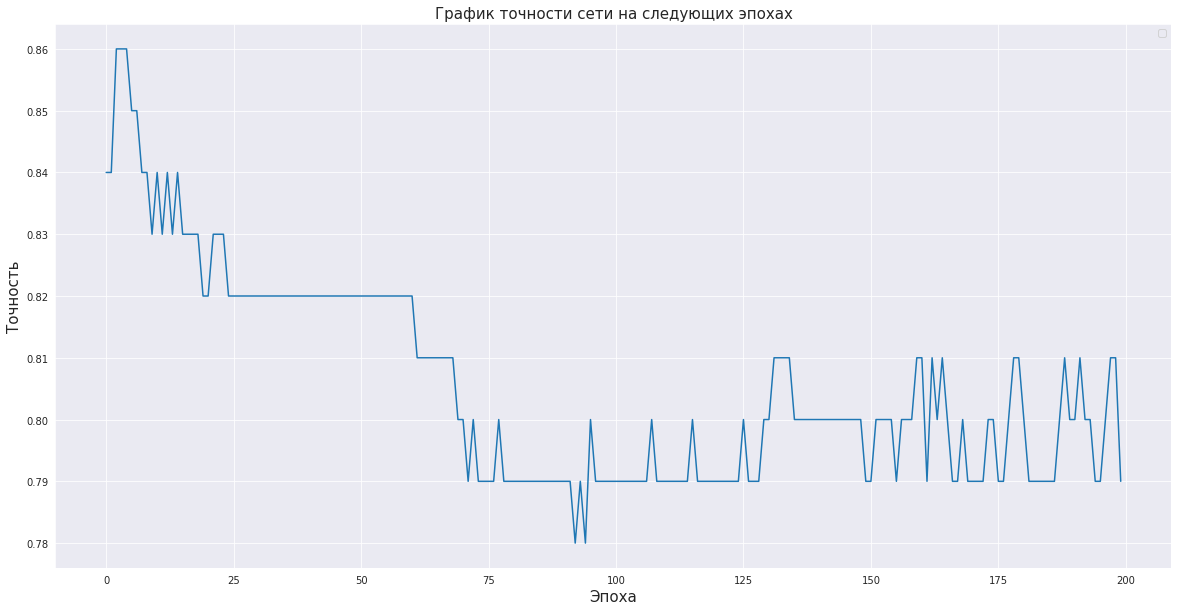

In [ ]:

plt.figure(figsize = (20,10))
plt.plot( history.history["val_accuracy"])

plt.legend()
plt.title('График точности сети на следующих эпохах', size = 15)
plt.xlabel('Эпоха', size = 15)
plt.ylabel('Точность', size = 15)
plt.show()